# Epymorph dev log: June 26th, 2023

_author: Tyler Coles_

_as of git hash: TBD_

In [1]:
from sympy import exp, log

from epymorph.ipm.attribute import geo, param
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder
from epymorph.ipm.compartment_model import (create_model, create_symbols, edge,
                                            quick_compartments)

# Create model

symbols = create_symbols(
    compartments=quick_compartments('S I R'),
    attributes=[
        param('D', 'infection_duration'),
        param('L', 'immunity_duration'),
        geo('H', 'humidity', shape='TxN'),
    ])

[S, I, R] = symbols.compartment_symbols
[D, L, H] = symbols.attribute_symbols

beta = (exp(-180 * H + log(2.0 - 1.3)) + 1.3) / D

pei = create_model(
    symbols=symbols,
    transitions=[
        edge(S, I, rate=beta * S * I / (S + I + R)),
        edge(I, R, rate=I / D),
        edge(R, S, rate=R / L)
    ])

ipm_builder = CompartmentModelIpmBuilder(pei)


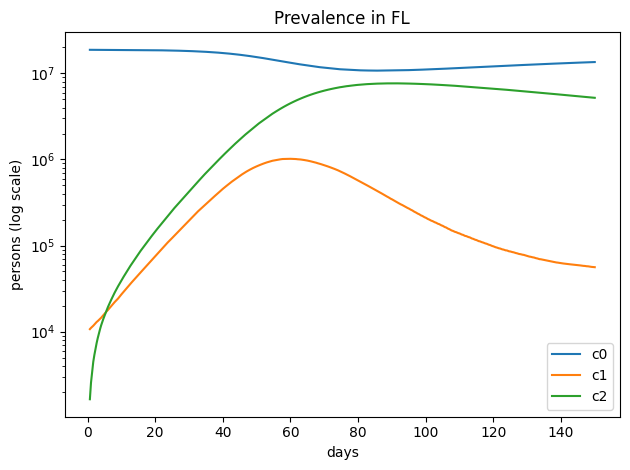

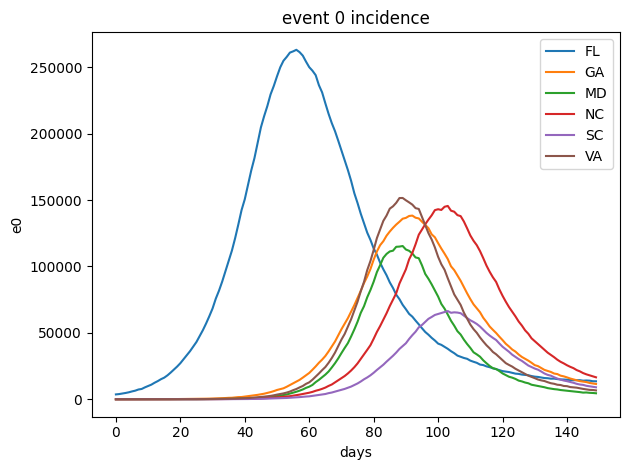

In [2]:
from datetime import date

from epymorph.data import geo_library, mm_library
from epymorph.run import plot_event, plot_pop
from epymorph.simulation import Simulation

# Run simulation

sim = Simulation(
    geo_library['pei'](),
    ipm_builder,
    mm_library['pei']())

out = sim.run(
    param={
        'theta': 0.1,
        'move_control': 0.9,
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
        'infection_seed_loc': 0,
        'infection_seed_size': 10_000
    },
    start_date=date(2015, 1, 1),
    duration_days=150
)

plot_pop(out, 0)
plot_event(out, 0)
